# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/6956f3d80ee4f03d93cb41f8fb139d87653aeb589114faa20bdb34df.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **None, None, United States**, and the stations the data comes from are shown on the map below.

In [1]:
## Find name of the target city

import matplotlib.pyplot as plt
import matplotlib as mt
import mplleaflet
import pandas as pd
import numpy as np

hashed_code='6956f3d80ee4f03d93cb41f8fb139d87653aeb589114faa20bdb34df'
bins=400

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    #plt.figure(figsize=(8,8))

    #plt.scatter(lons, lats, c='r', alpha=0.7, s=200)
    #return mplleaflet.display()
    return station_locations_by_hash


stations=leaflet_plot_stations(bins,hashed_code)
stations_ids=stations.loc[:,['ID','NAME','STATE','WMOID']]
target_city=(str(stations_ids[stations_ids.loc[:,'WMOID']>0]['NAME'].item()+","+
            stations_ids[stations_ids.loc[:,'WMOID']>0]['STATE'].item()))

print(target_city)

WICHITA,KS


In [3]:
## Get data from the file and remove extra days for leap years
import datetime
def get_data(binsize, hashid):
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d'+str(binsize)+'/'+str(hashid)+'.csv')
    return df


data=get_data(bins,hashed_code)
data=data.loc[(data['Date'].str[5:7]!='02') & (data['Date'].str[8:]!='29')]

print(data.head())

            ID        Date Element  Data_Value
0  USC00143930  2005-07-04    TMAX         344
1  USW00003974  2008-01-26    TMAX         139
2  USW00003974  2012-04-16    TMAX         194
3  USC00143545  2014-12-31    TMIN        -139
4  USC00148964  2008-07-15    TMAX         289


In [6]:
## Prepare data for plotting

import datetime

#Split data into two segments: before 2015 and only 2015 
data['Date'] = data['Date'].values.astype('datetime64[D]')
data['DayMonth'] = data['Date'].map(lambda x: x.strftime('%m %d'))
data['Month'] = data['Date'].map(lambda x: x.strftime('%B'))
data['Year'] = data['Date'].map(lambda x: x.strftime('%Y'))
data_no2015=data[data.loc[:,'Year']!='2015']
data_only2015=data[data.loc[:,'Year']=='2015']

#Find min and max temperature for every day of the year from 2005 to 2014 (data has multiple observations per day)
min_summarized=( pd.DataFrame(data_no2015[data_no2015.loc[:,'Element']=='TMIN']
                              .groupby(['DayMonth','Element','Month'])['Data_Value'].min()) )
max_summarized=( pd.DataFrame(data_no2015[data_no2015.loc[:,'Element']=='TMAX']
                              .groupby(['DayMonth','Element','Month'])['Data_Value'].max()) )
max_summarized.reset_index(inplace=True)
min_summarized.reset_index(inplace=True)

#Find min and max temperature for every day of the year in 2015 (data has multiple observations per day)
min_summarized_15=( pd.DataFrame(data_only2015[data_only2015.loc[:,'Element']=='TMIN']
                              .groupby(['DayMonth','Element','Month'])['Data_Value'].min()) )
max_summarized_15=( pd.DataFrame(data_only2015[data_only2015.loc[:,'Element']=='TMAX']
                              .groupby(['DayMonth','Element','Month'])['Data_Value'].max()) )
max_summarized_15.reset_index(inplace=True)
min_summarized_15.reset_index(inplace=True)

#Find record breaking temperatures in 2015 that are higher/lower than max/min of that day between 2005 and 2014
result_min = pd.merge(min_summarized, min_summarized_15, how='left', on=['DayMonth', 'Element'])
min_outliers= result_min[result_min.loc[:,'Data_Value_y']<result_min.loc[:,'Data_Value_x']]
result_max = pd.merge(max_summarized, max_summarized_15, how='left', on=['DayMonth', 'Element'])
max_outliers=result_max[result_max.loc[:,'Data_Value_y']>result_max.loc[:,'Data_Value_x']]


#Merge data set with min and max per day of the year based on 2005-2014 data with record breaking 2015 temperatures
data_min_with_outliers = pd.merge(min_summarized, min_outliers, how='left', on=['DayMonth', 'Element'])
data_max_with_outliers = pd.merge(max_summarized, max_outliers, how='left', on=['DayMonth', 'Element'])
print(data_min_with_outliers.head())

#Generate Numpy arrays from max of temperatures and from record breaking temperatures
temp_max=np.array(data_max_with_outliers['Data_Value']/10)
data_max_with_outliers.reset_index(inplace=True)
obs_dates_max=np.array(data_max_with_outliers.index)
temp_max_outliers=np.array(data_max_with_outliers['Data_Value_x']/10)

#Generate Numpy arrays from min of temperatures and from record breaking temperatures
temp_min=np.array(data_min_with_outliers['Data_Value']/10)
obs_dates_min=np.array(data_min_with_outliers.index)
months=np.array(data_min_with_outliers['Month'])
temp_min_outliers=np.array(data_min_with_outliers['Data_Value_x']/10)


  DayMonth Element    Month  Data_Value  Month_x  Data_Value_x  Month_y  \
0    01 01    TMIN  January        -156      NaN           NaN      NaN   
1    01 02    TMIN  January        -161      NaN           NaN      NaN   
2    01 03    TMIN  January        -161      NaN           NaN      NaN   
3    01 04    TMIN  January        -150  January        -150.0  January   
4    01 05    TMIN  January        -206      NaN           NaN      NaN   

   Data_Value_y  
0           NaN  
1           NaN  
2           NaN  
3        -155.0  
4           NaN  


<IPython.core.display.Javascript object>


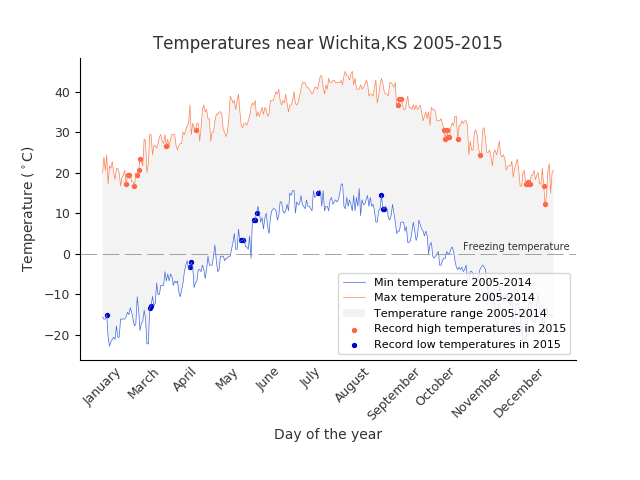

In [5]:
%matplotlib notebook

## Plotting
fig, ax = plt.subplots()

#Plot minimun temperatures
plt.plot(temp_min, '-',linewidth=0.5,color='royalblue')

#Plot maximum temperatures
plt.plot(temp_max, '-',linewidth=0.5,color='coral')

#Plot range of temperatures
plt.gca().fill_between(range(max(len(temp_min),len(temp_max))),
                       temp_max, temp_min,
                       facecolor='lightgray',
                       alpha=0.25)

#Add title, lables and 0 degree line
plt.title("Temperatures near Wichita,KS 2005-2015", loc='center', alpha=0.8,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Temperature ($^\circ$C)', alpha=0.8)
ax.set_xlabel('Day of the year',fontsize=10, alpha=0.8)
ax.axhline(linewidth=0.5, color="grey",dashes=[6, 2], label='_nolegend_')       

#Plot extreme temperatures in 2015
plt.scatter(obs_dates_max, temp_max_outliers, s=8,c='tomato', alpha=1)
plt.scatter(obs_dates_max, temp_min_outliers, s=8,c='mediumblue', alpha=1)

#Add legend and title for the 0 degree line
plt.legend(('Min temperature 2005-2014','Max temperature 2005-2014','Temperature range 2005-2014','Record high temperatures in 2015'
            ,'Record low temperatures in 2015'),loc='lower right',fontsize=8)

plt.text(260, 1, 'Freezing temperature',fontsize=7, alpha=0.8)

#Add ticks on y axis and labes on x axis
plt.xticks(obs_dates_min,months, fontsize=9,alpha=0.8)
plt.yticks( fontsize=9, alpha=0.8)

#Make visible only every 30th labes on x axis
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
plt.locator_params(axis='x')

for label in ax.xaxis.get_ticklabels()[::30]:
    label.set_visible(True)
plt.locator_params(axis='x')

#Rotate x axis lables
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45)
plt.subplots_adjust(bottom=0.25)

#Remove ticks form z axis
ax.tick_params(axis=u'x', which=u'both',length=0)

#Save the image
#fig.savefig('Natalia_Kukushkina_Assignment2.png', bbox_inches='tight', pad_inches=0)
